<b>Project description</b>

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.



In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt

users = pd.read_csv('/datasets/megaline_users.csv')
plans= pd.read_csv('/datasets/megaline_plans.csv')
calls= pd.read_csv('/datasets/megaline_calls.csv')
internet= pd.read_csv('/datasets/megaline_internet.csv')
messages=pd.read_csv('/datasets/megaline_messages.csv')

## Preparing The Data

<ul>
<li>Converting the data to the necessary types</li>
<li>Finding and eliminating errors in the data</li>
<li>Explaining what errors you found and how to removed them.</li>
<li>For each user, finding:<br>
-The number of calls made and minutes used per month<br>
-The number of text messages sent per month<br>
-The volume of data per month<br>
-The monthly revenue from each user.</li>
</ul>



In [2]:
#Checking for null values in  dataframes 
users.isnull().sum()
#plans.isnull().sum()
#calls.isnull().sum()
#internet.isnull().sum()
#messages.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Null values are present in churn_date. However, this column doesn't play a huge role in our analysis. We will not worry about it for now

In [3]:
#converting the datatype of date column from string to `datetime` in  each dataset
users['reg_date']=pd.to_datetime(users['reg_date'])
calls['call_date']=pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [4]:
#converting the datetime columns in calls, messages and internet to monthly periods

calls['month_year']=calls['call_date'].dt.to_period('M')
messages['month_year']=messages['message_date'].dt.to_period('M')
internet['month_year']=internet['session_date'].dt.to_period('M')

In [5]:
#rounding the call duration value to the maximum nearest integer values

calls['duration_call'] = np.ceil(calls['duration']).astype(int)

#dropping the orignial duration column

calls.drop('duration', axis= 1, inplace=True)
calls.head()

,id,user_id,call_date,month_year,duration_call
0,1000_93,1000,2018-12-27,2018-12,9
1,1000_145,1000,2018-12-27,2018-12,14
2,1000_247,1000,2018-12-27,2018-12,15
3,1000_309,1000,2018-12-28,2018-12,6
4,1000_380,1000,2018-12-30,2018-12,5


In [6]:
#calculating the total calls for each user by month

total_calls_per_month = calls.pivot_table(index=['user_id','month_year'], values='id', aggfunc='count')
total_calls_per_month.head()

id
user_id month_year    
1000    2018-12     16
1001    2018-08     27
        2018-09     49
        2018-10     65
        2018-11     64

In [7]:
#calculating the total minutesfor each user  by month

total_mins_per_month = calls.pivot_table(index=['user_id','month_year'], values='duration_call', aggfunc='sum')
total_mins_per_month.head()

duration_call
user_id month_year               
1000    2018-12               124
1001    2018-08               182
        2018-09               315
        2018-10               393
        2018-11               426

In [8]:
#calculating the total messages for each user by month

total_messages_per_month = messages.pivot_table(index=['user_id','month_year'], values='message_date', aggfunc='count')
total_messages_per_month.head()

message_date
user_id month_year              
1000    2018-12               11
1001    2018-08               30
        2018-09               44
        2018-10               53
        2018-11               36

In [9]:
#calculating the total GB's for each user by month 

internet['GB_conversion'] = internet['mb_used']/1024
internet['GB_used']= np.ceil(internet['GB_conversion'])
total_internet_per_month = internet.pivot_table(index=['user_id','month_year'], values='GB_used', aggfunc='sum')
total_internet_per_month.head()


GB_used
user_id month_year         
1000    2018-12         4.0
1001    2018-08        21.0
        2018-09        41.0
        2018-10        50.0
        2018-11        49.0

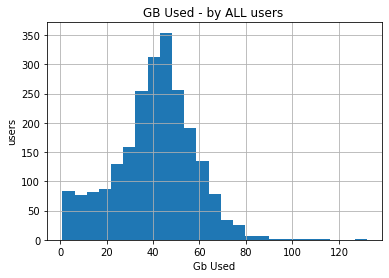

In [10]:
total_internet_per_month.hist('GB_used', bins=25)
plt.title('GB Used - by ALL users ')
plt.xlabel('Gb Used')
plt.ylabel('users')
plt.show()

This data is somewhat shaped like a normal distribution curve. Mean, standard deviations, plans comparison will be analyzed in Section 2. But we can already see that most users exceeded their data plan montly limits. 

Concatenating all above four dataframes into single dataframe total

In [11]:
total= pd.concat([total_calls_per_month,total_mins_per_month,total_messages_per_month, total_internet_per_month],1).reset_index().fillna(0)

#creating names of column for total dataframes

total.columns = ['user_id', 'month_year', 'tot_calls', 'tot_duration', 'tot_mess', 'Tot_GB']

#merging dataframes total and users on user_id
total= total.merge(users, on='user_id')
total.head()


,user_id,month_year,tot_calls,tot_duration,tot_mess,Tot_GB,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,2018-12,16.0,124.0,11.0,4.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,2018-08,27.0,182.0,30.0,21.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1001,2018-09,49.0,315.0,44.0,41.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
3,1001,2018-10,65.0,393.0,53.0,50.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
4,1001,2018-11,64.0,426.0,36.0,49.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN


In [12]:
# Adding columns function for adding column based on plan

def add_columns(col):
    total[col] = 0
    for i in range(0,len(total)):
        if total.plan[i] == 'surf':
            total[col].loc[i] = plans.loc[0][col]
        elif total.plan[i] == 'ultimate':
            total[col].loc[i] = plans.loc[1][col]

In [13]:
#function call to add usd_per_message column
add_columns('usd_per_message')
#function call to add usd_per_gb column
add_columns('usd_per_gb')
#function call to add usd_per_minute column
add_columns('usd_per_minute')
#function call to add mb_per_month_included column
add_columns('mb_per_month_included')
#function call to add minutes_included column
add_columns('minutes_included')
#function call to add messages_included column
add_columns('messages_included')
#function call to add usd_monthly_pay column
add_columns('usd_monthly_pay')

In [14]:
#adding gb_per_month_included column from mb_per_month_included column

total['gb_per_month_included'] = np.ceil(total['mb_per_month_included'] / 1024)

#dropping mb_per_month_included column
total.drop('mb_per_month_included',axis=1, inplace=True)
total.head(3)

,user_id,month_year,tot_calls,tot_duration,tot_mess,Tot_GB,first_name,last_name,age,city,reg_date,plan,churn_date,usd_per_message,usd_per_gb,usd_per_minute,minutes_included,messages_included,usd_monthly_pay,gb_per_month_included
0,1000,2018-12,16.0,124.0,11.0,4.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,0.01,7,0.01,3000,1000,70,30.0
1,1001,2018-08,27.0,182.0,30.0,21.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,0.03,10,0.03,500,50,20,15.0
2,1001,2018-09,49.0,315.0,44.0,41.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,0.03,10,0.03,500,50,20,15.0


In [15]:
#adding message_cost column
total['message_cost'] = 0
for i in range(0,len(total)):
    total['message_cost'].loc[i] = max(0, total['tot_mess'].loc[i] - total['messages_included'].loc[i])*total['usd_per_message'].loc[i]

In [16]:
#adding call_cost column
total['call_cost'] = 0
for i in range(0,len(total)):
    total['call_cost'].loc[i] = max(0, total['tot_duration'].loc[i] - total['minutes_included'].loc[i])*total['usd_per_minute'].loc[i]

In [17]:
#adding gb_cost column
total['gb_cost'] = 0
for i in range(0,len(total)):
    total['gb_cost'].loc[i] = max(0, total['Tot_GB'].loc[i] - total['gb_per_month_included'].loc[i])*total['usd_per_gb'].loc[i]

In [18]:
#adding total_cost column
total['total_cost'] = total['message_cost'] + total['call_cost'] + total['gb_cost'] + total['usd_monthly_pay']

In [19]:
#printing first 3 rows of total dataframe
total.head(3)

,user_id,month_year,tot_calls,tot_duration,tot_mess,Tot_GB,first_name,last_name,age,city,...,usd_per_gb,usd_per_minute,minutes_included,messages_included,usd_monthly_pay,gb_per_month_included,message_cost,call_cost,gb_cost,total_cost
0,1000,2018-12,16.0,124.0,11.0,4.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,7,0.01,3000,1000,70,30.0,0.0,0.0,0.0,70.0
1,1001,2018-08,27.0,182.0,30.0,21.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,500,50,20,15.0,0.0,0.0,60.0,80.0
2,1001,2018-09,49.0,315.0,44.0,41.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",...,10,0.03,500,50,20,15.0,0.0,0.0,260.0,280.0


In [20]:
total['monthly_profit'] = 0
def monthly_profit():
    mess_profit = (total['messages_included'] - total['tot_mess'])*total['usd_per_minute']
    min_profit = (total['minutes_included'] - total['tot_duration'])*total['usd_per_minute']
    gb_profit = (total['minutes_included'] - total['tot_duration'])*total['usd_per_minute']
    

In [21]:
(total['minutes_included'] - total['tot_duration'])*total['usd_per_minute']

0       28.76
1        9.54
2        5.55
3        3.21
4        2.22
        ...  
2288     4.83
2289     4.62
2290     3.45
2291     5.76
2292     0.12
Length: 2293, dtype: float64

In [22]:
def monthly(col):
    total[col] = 0
    for i in range(0,len(total)):
        if total.plan[i] == 'surf':
            mess_profit = ( total.loc[i]['tot_mess'] - plans.loc[0]['messages_included'])*plans.loc[0]['usd_per_minute']
            min_profit = ( total.loc[i]['tot_duration'] - plans.loc[0]['minutes_included'])*plans.loc[0]['usd_per_minute']
            gb_profit = (total.loc[i]['Tot_GB'] - total.loc[i]['gb_per_month_included'])*plans.loc[0]['usd_per_gb']
            total[col].loc[i] = mess_profit + min_profit + gb_profit
        elif total.plan[i] == 'ultimate':
            mess_profit = (total.loc[i]['tot_mess'] - plans.loc[1]['messages_included'])*plans.loc[1]['usd_per_minute']
            min_profit = (total.loc[i]['tot_duration'] - plans.loc[1]['minutes_included'])*plans.loc[1]['usd_per_minute']
            gb_profit = (total.loc[i]['Tot_GB'] - total.loc[i]['gb_per_month_included'])*plans.loc[1]['usd_per_gb']
            total[col].loc[i] = mess_profit + min_profit + gb_profit
            
#monthly('monthly_profit') 

In [23]:
total.tail(6)

,user_id,month_year,tot_calls,tot_duration,tot_mess,Tot_GB,first_name,last_name,age,city,...,usd_per_minute,minutes_included,messages_included,usd_monthly_pay,gb_per_month_included,message_cost,call_cost,gb_cost,total_cost,monthly_profit
2287,1498,2018-11,41.0,223.0,0.0,47.0,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",...,0.03,500,50,20,15.0,0.0,0.0,320.0,340.0,0
2288,1498,2018-12,39.0,339.0,0.0,56.0,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",...,0.03,500,50,20,15.0,0.0,0.0,410.0,430.0,0
2289,1499,2018-09,41.0,346.0,0.0,37.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",...,0.03,500,50,20,15.0,0.0,0.0,220.0,240.0,0
2290,1499,2018-10,53.0,385.0,0.0,52.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",...,0.03,500,50,20,15.0,0.0,0.0,370.0,390.0,0
2291,1499,2018-11,45.0,308.0,0.0,43.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",...,0.03,500,50,20,15.0,0.0,0.0,280.0,300.0,0
2292,1499,2018-12,65.0,496.0,0.0,58.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",...,0.03,500,50,20,15.0,0.0,0.0,430.0,450.0,0


## Analyzing The Data 2

In [24]:
# creating seperate dataframes for each plan for plotting data
surf = total.loc[total['plan'] == 'surf']
ultimate = total.loc[total['plan'] == 'ultimate']

In [25]:
#Mean, dispersion and standard deviation for Number of Minutes Required by Each Plan User
total.groupby(['plan'])['tot_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


Based on the Mean, dispersion, and standard deviation of the ALL the scenarios above, in addition to the Graphs displayed, we can conclude that although the 'Surf plan' has double the subcribers of the 'Ultimate plan', Their means are almost the same.

<blockquote> added comment above v.2 </blockquote>

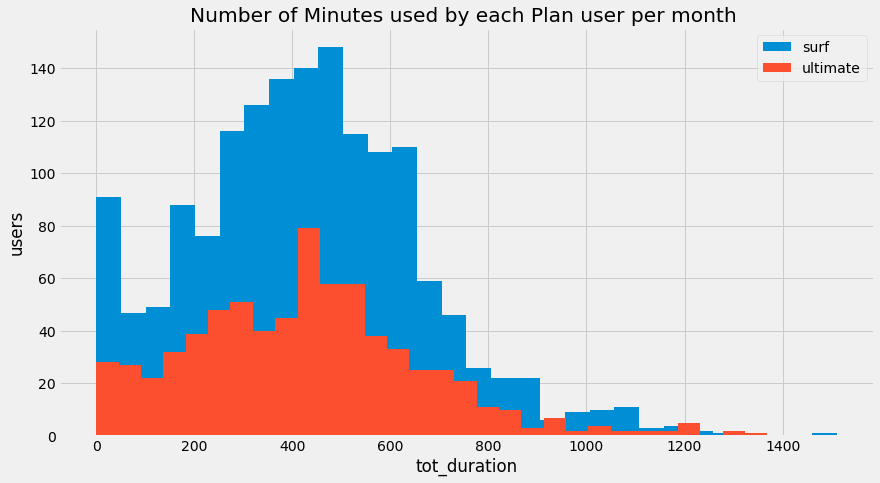

In [26]:
#Plotting the Number of Minutes Required by Each Plan User
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize = (13,7))
plt.hist(surf['tot_duration'], bins = 30)
plt.hist(ultimate['tot_duration'], bins = 30)
plt.legend(['surf','ultimate'])
plt.title('Number of Minutes used by each Plan user per month ')
plt.xlabel('tot_duration')
plt.ylabel('users')
plt.show()

The data shows that most users are staying within the plan limit. No "ultimate" plan user has exceeded the 3000 minutes allowed by the plan. A portion of  "surf" users have exceed the 500minutes allowed by the plan

In [27]:
#Mean, dispersion and standard deviation for Number of Messages Required by Each Plan User
total.groupby(['plan'])['tot_mess'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,31.159568,33.566717,0.0,3.0,24.0,47.0,266.0
ultimate,720.0,37.551389,34.767179,0.0,7.0,30.0,61.0,166.0


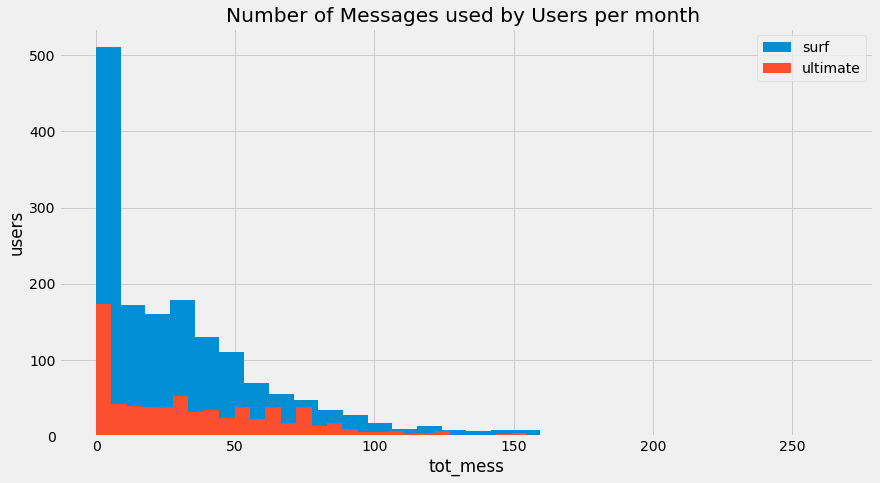

In [28]:
#Plotting the Number of Messeges Required by Each Plan User
plt.figure(figsize = (13,7))
plt.hist(surf['tot_mess'], bins = 30)
plt.hist(ultimate['tot_mess'], bins = 30)
plt.legend(['surf','ultimate'])
plt.title('Number of Messages used by Users per month ')
plt.xlabel('tot_mess')
plt.ylabel('users')
plt.show()

This graph shows that most users don't use the SMS feature. No "ultimate" user has exceed the 1000 messages included with the plan. A few users from the surf plan have exceed their 50 messages monthly quotas. This can be explained by the fact that users have data plans and are most likely using apps like "Messenger" - 'Whatsapp' - " Signal"...and more to communicate. 

In [29]:
#Mean, dispersion and standard deviation for Number of Gb's Required by Each Plan User
total.groupby(['plan'])['Tot_GB'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,40.140496,17.841862,0.0,30.0,42.0,52.0,132.0
ultimate,720.0,41.080556,16.528701,0.0,32.0,42.0,51.0,96.0


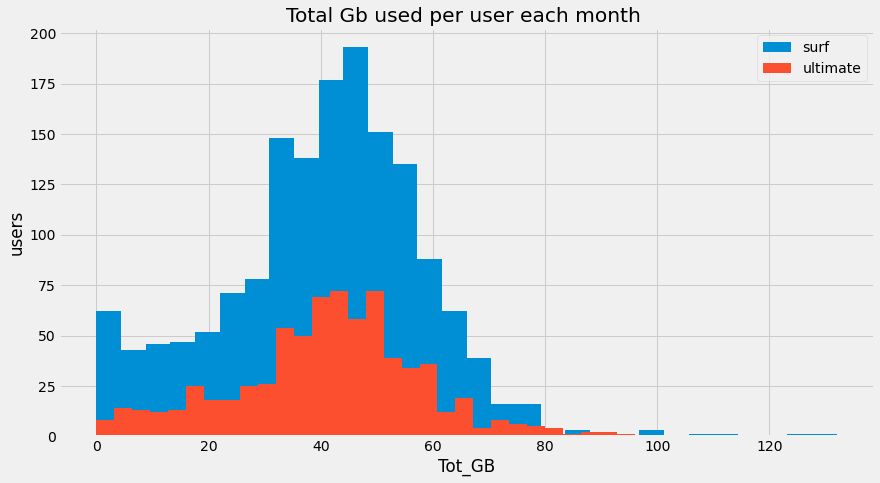

In [30]:
#Plotting the Number of Gb's Required by Each Plan User
plt.figure(figsize = (13,7))
plt.hist(surf['Tot_GB'], bins = 30)
plt.hist(ultimate['Tot_GB'], bins = 30)
plt.legend(['surf','ultimate'])
plt.title('Total Gb used per user each month ')
plt.xlabel('Tot_GB')
plt.ylabel('users')
plt.show()

The grapth shows that users of the surf plan are using significantly more data that the users from the ultimate plan. The data also shows that approximately 75% of the surf users exceeded their montly quotas. Most users ( from both plans) use between 20-70 GB of data per month. 

### Analysis based on the above data

Based on the Mean, dispersion, and standard deviation of the ALL the scenarios above, in addition to the Graphs displayed, we can conclude that although the 'Surf plan' has double the subcribers of the 'Ultimate plan', Their means are almost the same. The charts also clearly demonstrate that users of the Ultimate plan almost never exceed their monthly quotas, the surf plan subscribers on the other hand, tend to exceed their monthly quotas everytime specially on the Data usage in GB. 

Let's take a look at the first 2-3 users on the list to support our case here: 

Ana-Maria Bauer (user_id: 1000) has the ultimate plan she did not exceed her monthly limits on calls ,texts and Data so total monthly should be 70 Dollars

Carlee HOffman ( user_id: 1002) has the surf plan she did not exceed her montly limits on calls, texts but did use 40 GB of data  so 40 GB- 15GB = 



Based on the analysis so far, the most important source of revenue is the Data comsumption per GB. So that is what I will use to determine my outliers.

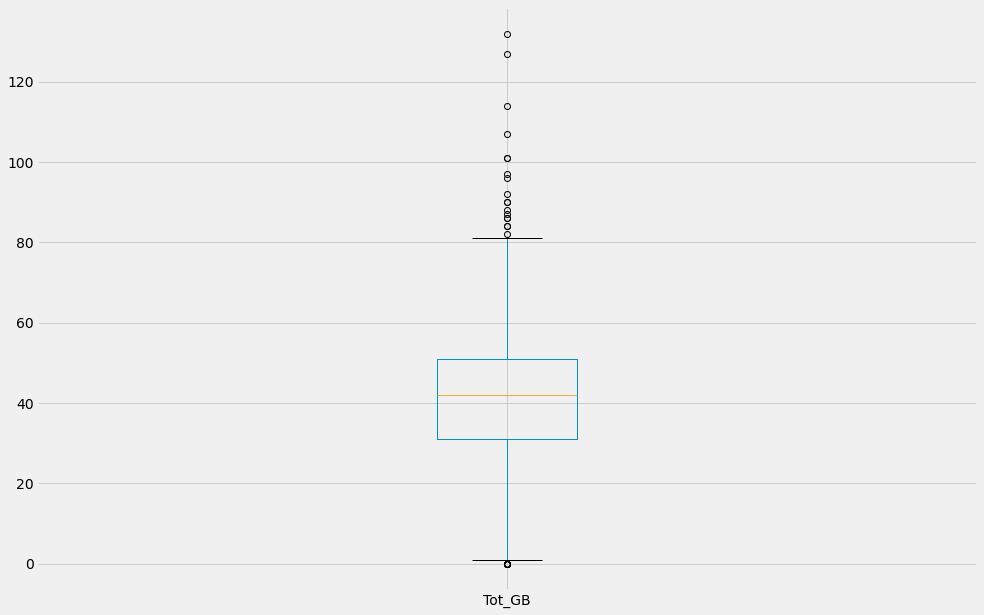

In [31]:
total.boxplot(column='Tot_GB', figsize=(15,10))
plt.show( )

In [32]:
# removing the outliers.

total[total['Tot_GB'] > 100].index
total.drop(total[total['Tot_GB'] > 100].index , inplace=True)


The Box plot clearly shows the average user consumes on average 42 GB of data. Customers using 80+GB of data /month start being questionable some of them maybe running a small business on these plans. However, cases of 100+ GB /months are isolated and must be removed to preserve the accuracy of the data analysis. 

<blockquote> added comment above v.2</blockquote>

## Hypothesis Testing 1
### Null hypothesis :  Average revenue of the Ultimate and Surf Calling Plans differs

<ul>
<li>Ho: Average revenue of the Ultimate and Surf Calling Plans don't differs</li>
<li>H11 ( alternative hypothesis):Average revenue of the Ultimate and Surf Calling are different</li>
<li>typical alpha = 0.05</li>
</ul>

In [33]:
# Testing the hypothesis that Average revenue of the Ultimate and Surf Calling Plans differs
from scipy.stats import ttest_ind
from scipy import stats

print(stats.ttest_ind(surf['total_cost'],ultimate['total_cost'], equal_var = True))

ttest, pval = ttest_ind(surf['total_cost'],ultimate['total_cost'])
print("P-value is",pval)
if(pval < 0.05):
    print("Reject the Null hypothesis (Average revenue of the Ultimate and Surf Calling are different) ")
else:
    print("Accept the Null hypothesis (Average revenue of the Ultimate and Surf Calling Plans don't differs)")


Ttest_indResult(statistic=17.849353175598566, pvalue=7.954135633536331e-67)
P-value is 7.954135633536331e-67
Reject the Null hypothesis (Average revenue of the Ultimate and Surf Calling are different) 


#### Brief Analysis:
Based on the fact that both plans have the same mean and the same Variance, it is tempting to assume that Average revenue of the Ultimate and Surf Calling are the same well in fact they are different. Accoring to the total cost or monthly revenue per user, it is clear that surf plan users use more data therefore are more profitable. 

## Hypothesis Testing 2
### Null hypothesis :  Average revenue from users in NY-NJ areas differ from other areas

<div class="alert alert-danger" role="alert">
Reviewer's comment v. 2:
    
Please check the null hypothesis formulation and add alternative hypothesis.
</div>

In [34]:
#creating the dataframe from users in NY-NJ areas
nj_ny = total[total['city'].str.contains('NY-NJ')]
nj_ny.shape

(377, 25)

In [35]:
#creating the dataframe from users in other areas
others = total[total['city'].str.contains('NY-NJ') == False]

<ul>
<li>Ho: Average revenue from users in NY-Nj areas does not differ from other areas</li>
<li>H11 ( alternative hypothesis):hypothesis that Average revenue from users in NY-Nj areas differ from other areas</li>
<li>typical alpha = 0.05</li>
</ul>

In [36]:
# Testing the hypothesis that Average revenue from users in NY-Nj areas differ from other ares

print(stats.ttest_ind(nj_ny['total_cost'],others['total_cost'], equal_var = True))

#ttest,pval = ttest_ind(nj_ny['total_cost'],others['total_cost'])
#print("P-value is", pval)
if(pval < 0.05):
    print("Reject the Null hypothesis (hypothesis that Average revenue from users in NY-Nj areas differ from other ares) ")
else:
    print("Accept the Null hypothesis (Average revenue from users in NY-Nj areas does not differ from other areas)")

Ttest_indResult(statistic=3.120387713772901, pvalue=0.0018286876820398687)
Reject the Null hypothesis (hypothesis that Average revenue from users in NY-Nj areas differ from other ares) 


#### Brief Analysis:
Users from New York and New Jersey are using more data than people over other cities. Looking at the data, some high data consumption came from these cities. Perhaps  some subscribers are using it for small businessess or work from home internet. 

## Conclusion 2

<i>The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget. </i>

The data presented to be studied was clean enough. No duplicates , some Null values are present in 'churn_date' column. However, this column doesn't play a huge role in our analysis, the column was left untouched. The data does not have many outliers ( a few records over 100 GB for a personal plan seems a bit excesive though) - Those values were removed.  

Based on the analyzed data, surf plan subscribers always exceed their monthly quota limits which leads to additional fees that adds up to a huge montly cost higher than most Ultimate plan users. The advertising budget should focus on promoting the Surf plan. Everyone needs data these days - Advertising a plan that sells 10 dollars /GB vs a plan that sells it for 7 dollars /GB is the right way to go considering that some users go up to 80GB /Month. 

Now if the company decides to eliminate the charges after exceeding the package limits and move on into A simple flat fee monthly program with set quotas, then the Ultimate plan will become the most profitable one ( but this is not the most profitable approch) 

The current charge/plan sturcture makes sense. Keep offering users a low montly plan on non essential services and keep the most valuable feature on a smart tariffs, whith the rise of smarphones, data comsumption will keep going up, calls and texts will certainely be made from third party applications running on a GB plan - Apps like WhatsApp, Signal, Messenger....

